# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [1]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras

In [2]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [3]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
    print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [4]:
def create_midi(tempo, transcription, ticks_per_beat, file_name):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track
    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
    print(new_mid)
    new_mid.save(file_name)

In [5]:
mid, drum_track = open_midi('./RHCP_midi/FortuneFaded.mid')

Drum track number:  4


In [6]:
transcription = get_transcription(drum_track, mid)
# print(transcription)
# for i in transcription:
#     print(i)
# find all instruments in song
instruments = transcription.columns.tolist()

120.0


In [7]:
print(transcription)

note  36  40  42  46  48  49
0      1   1   0   0   0   0
1      0   0   0   0   0   0
2      0   1   0   0   0   0
3      0   0   0   0   0   0
4      0   1   0   0   0   0
...   ..  ..  ..  ..  ..  ..
3160   1   0   1   0   1   0
3161   0   0   0   0   0   0
3162   0   0   0   0   0   0
3163   0   0   0   0   0   0
3164   1   1   1   0   0   0

[3165 rows x 6 columns]


In [8]:
inputs_list = []
outputs_list = []
sequence_len = 64
raw_notes = transcription.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

In [9]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=500, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

2021-12-31 14:50:15.358871: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 84,614
Trainable params: 84,614
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2021-12-31 14:50:15.999930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


88/88 [==============================] - 8s 55ms/step - loss: 0.3034 - accuracy: 0.4057 - binary_crossentropy: 0.3034 - val_loss: 0.2849 - val_accuracy: 0.0643 - val_binary_crossentropy: 0.2849

Epoch 00001: val_loss improved from inf to 0.28494, saving model to ./new_encode_1st_try.h5
Epoch 2/500
88/88 [==============================] - 4s 45ms/step - loss: 0.2615 - accuracy: 0.4989 - binary_crossentropy: 0.2615 - val_loss: 0.2858 - val_accuracy: 0.9068 - val_binary_crossentropy: 0.2858

Epoch 00002: val_loss did not improve from 0.28494
Epoch 3/500
88/88 [==============================] - 4s 48ms/step - loss: 0.2605 - accuracy: 0.5663 - binary_crossentropy: 0.2605 - val_loss: 0.2862 - val_accuracy: 0.9068 - val_binary_crossentropy: 0.2862

Epoch 00003: val_loss did not improve from 0.28494
Epoch 4/500
88/88 [==============================] - 7s 77ms/step - loss: 0.2599 - accuracy: 0.6323 - binary_crossentropy: 0.2599 - val_loss: 0.2868 - val_accuracy: 0.9068 - val_binary_crossentropy

88/88 [==============================] - 6s 64ms/step - loss: 0.1030 - accuracy: 0.6262 - binary_crossentropy: 0.1030 - val_loss: 0.1443 - val_accuracy: 0.6045 - val_binary_crossentropy: 0.1443

Epoch 00030: val_loss did not improve from 0.14390
Epoch 31/500
88/88 [==============================] - 5s 58ms/step - loss: 0.1004 - accuracy: 0.5914 - binary_crossentropy: 0.1004 - val_loss: 0.1431 - val_accuracy: 0.5756 - val_binary_crossentropy: 0.1431

Epoch 00031: val_loss improved from 0.14390 to 0.14309, saving model to ./new_encode_1st_try.h5
Epoch 32/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0947 - accuracy: 0.5835 - binary_crossentropy: 0.0947 - val_loss: 0.1521 - val_accuracy: 0.6013 - val_binary_crossentropy: 0.1521

Epoch 00032: val_loss did not improve from 0.14309
Epoch 33/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0906 - accuracy: 0.5935 - binary_crossentropy: 0.0906 - val_loss: 0.1388 - val_accuracy: 0.6334 - val_binary_cross

88/88 [==============================] - 5s 54ms/step - loss: 0.0523 - accuracy: 0.5147 - binary_crossentropy: 0.0523 - val_loss: 0.0523 - val_accuracy: 0.4630 - val_binary_crossentropy: 0.0523

Epoch 00059: val_loss improved from 0.05565 to 0.05233, saving model to ./new_encode_1st_try.h5
Epoch 60/500
88/88 [==============================] - 5s 53ms/step - loss: 0.0515 - accuracy: 0.5229 - binary_crossentropy: 0.0515 - val_loss: 0.0591 - val_accuracy: 0.5177 - val_binary_crossentropy: 0.0591

Epoch 00060: val_loss did not improve from 0.05233
Epoch 61/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0478 - accuracy: 0.5014 - binary_crossentropy: 0.0478 - val_loss: 0.0518 - val_accuracy: 0.4598 - val_binary_crossentropy: 0.0518

Epoch 00061: val_loss improved from 0.05233 to 0.05179, saving model to ./new_encode_1st_try.h5
Epoch 62/500
88/88 [==============================] - 5s 53ms/step - loss: 0.0493 - accuracy: 0.5194 - binary_crossentropy: 0.0493 - val_loss: 0.0


Epoch 00088: val_loss did not improve from 0.04168
Epoch 89/500
88/88 [==============================] - 5s 58ms/step - loss: 0.0403 - accuracy: 0.6136 - binary_crossentropy: 0.0403 - val_loss: 0.0426 - val_accuracy: 0.7138 - val_binary_crossentropy: 0.0426

Epoch 00089: val_loss did not improve from 0.04168
Epoch 90/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0386 - accuracy: 0.6194 - binary_crossentropy: 0.0386 - val_loss: 0.0431 - val_accuracy: 0.6495 - val_binary_crossentropy: 0.0431

Epoch 00090: val_loss did not improve from 0.04168
Epoch 91/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0355 - accuracy: 0.6265 - binary_crossentropy: 0.0355 - val_loss: 0.0441 - val_accuracy: 0.7138 - val_binary_crossentropy: 0.0441

Epoch 00091: val_loss did not improve from 0.04168
Epoch 92/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0385 - accuracy: 0.6315 - binary_crossentropy: 0.0385 - val_loss: 0.0433 - val_accuracy: 0.646

Epoch 119/500
88/88 [==============================] - 6s 73ms/step - loss: 0.0323 - accuracy: 0.6527 - binary_crossentropy: 0.0323 - val_loss: 0.0393 - val_accuracy: 0.7074 - val_binary_crossentropy: 0.0393

Epoch 00119: val_loss did not improve from 0.03807
Epoch 120/500
88/88 [==============================] - 5s 61ms/step - loss: 0.0325 - accuracy: 0.6577 - binary_crossentropy: 0.0325 - val_loss: 0.0389 - val_accuracy: 0.6302 - val_binary_crossentropy: 0.0389

Epoch 00120: val_loss did not improve from 0.03807
Epoch 121/500
88/88 [==============================] - 5s 59ms/step - loss: 0.0338 - accuracy: 0.6724 - binary_crossentropy: 0.0338 - val_loss: 0.0387 - val_accuracy: 0.6463 - val_binary_crossentropy: 0.0387

Epoch 00121: val_loss did not improve from 0.03807
Epoch 122/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0305 - accuracy: 0.6789 - binary_crossentropy: 0.0305 - val_loss: 0.0390 - val_accuracy: 0.6785 - val_binary_crossentropy: 0.0390

Epoch 00122

88/88 [==============================] - 5s 57ms/step - loss: 0.0281 - accuracy: 0.6455 - binary_crossentropy: 0.0281 - val_loss: 0.0375 - val_accuracy: 0.6527 - val_binary_crossentropy: 0.0375

Epoch 00150: val_loss did not improve from 0.03739
Epoch 151/500
88/88 [==============================] - 5s 59ms/step - loss: 0.0266 - accuracy: 0.6405 - binary_crossentropy: 0.0266 - val_loss: 0.0369 - val_accuracy: 0.6527 - val_binary_crossentropy: 0.0369

Epoch 00151: val_loss improved from 0.03739 to 0.03691, saving model to ./new_encode_1st_try.h5
Epoch 152/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0296 - accuracy: 0.6466 - binary_crossentropy: 0.0296 - val_loss: 0.0392 - val_accuracy: 0.6495 - val_binary_crossentropy: 0.0392

Epoch 00152: val_loss did not improve from 0.03691
Epoch 153/500
88/88 [==============================] - 5s 57ms/step - loss: 0.0262 - accuracy: 0.6749 - binary_crossentropy: 0.0262 - val_loss: 0.0378 - val_accuracy: 0.5981 - val_binary_cr

88/88 [==============================] - 5s 55ms/step - loss: 0.0357 - accuracy: 0.5570 - binary_crossentropy: 0.0357 - val_loss: 0.0422 - val_accuracy: 0.6752 - val_binary_crossentropy: 0.0422

Epoch 00181: val_loss did not improve from 0.03647
Epoch 182/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0274 - accuracy: 0.6735 - binary_crossentropy: 0.0274 - val_loss: 0.0382 - val_accuracy: 0.6752 - val_binary_crossentropy: 0.0382

Epoch 00182: val_loss did not improve from 0.03647
Epoch 183/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0240 - accuracy: 0.6165 - binary_crossentropy: 0.0240 - val_loss: 0.0382 - val_accuracy: 0.6463 - val_binary_crossentropy: 0.0382

Epoch 00183: val_loss did not improve from 0.03647
Epoch 184/500
88/88 [==============================] - 5s 53ms/step - loss: 0.0263 - accuracy: 0.6254 - binary_crossentropy: 0.0263 - val_loss: 0.0414 - val_accuracy: 0.6817 - val_binary_crossentropy: 0.0414

Epoch 00184: val_loss did

88/88 [==============================] - 5s 54ms/step - loss: 0.0216 - accuracy: 0.6168 - binary_crossentropy: 0.0216 - val_loss: 0.0378 - val_accuracy: 0.3151 - val_binary_crossentropy: 0.0378

Epoch 00212: val_loss did not improve from 0.03294
Epoch 213/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0224 - accuracy: 0.6290 - binary_crossentropy: 0.0224 - val_loss: 0.0336 - val_accuracy: 0.5627 - val_binary_crossentropy: 0.0336

Epoch 00213: val_loss did not improve from 0.03294
Epoch 214/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0199 - accuracy: 0.6000 - binary_crossentropy: 0.0199 - val_loss: 0.0338 - val_accuracy: 0.5563 - val_binary_crossentropy: 0.0338

Epoch 00214: val_loss did not improve from 0.03294
Epoch 215/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0213 - accuracy: 0.6043 - binary_crossentropy: 0.0213 - val_loss: 0.0354 - val_accuracy: 0.6527 - val_binary_crossentropy: 0.0354

Epoch 00215: val_loss did

88/88 [==============================] - 5s 55ms/step - loss: 0.0210 - accuracy: 0.5502 - binary_crossentropy: 0.0210 - val_loss: 0.0333 - val_accuracy: 0.5466 - val_binary_crossentropy: 0.0333

Epoch 00243: val_loss did not improve from 0.03094
Epoch 244/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0214 - accuracy: 0.5559 - binary_crossentropy: 0.0214 - val_loss: 0.0333 - val_accuracy: 0.5016 - val_binary_crossentropy: 0.0333

Epoch 00244: val_loss did not improve from 0.03094
Epoch 245/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0195 - accuracy: 0.5448 - binary_crossentropy: 0.0195 - val_loss: 0.0348 - val_accuracy: 0.5466 - val_binary_crossentropy: 0.0348

Epoch 00245: val_loss did not improve from 0.03094
Epoch 246/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0211 - accuracy: 0.5211 - binary_crossentropy: 0.0211 - val_loss: 0.0329 - val_accuracy: 0.5016 - val_binary_crossentropy: 0.0329

Epoch 00246: val_loss did


Epoch 00273: val_loss did not improve from 0.02706
Epoch 274/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0178 - accuracy: 0.6029 - binary_crossentropy: 0.0178 - val_loss: 0.0307 - val_accuracy: 0.5788 - val_binary_crossentropy: 0.0307

Epoch 00274: val_loss did not improve from 0.02706
Epoch 275/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0188 - accuracy: 0.5950 - binary_crossentropy: 0.0188 - val_loss: 0.0302 - val_accuracy: 0.6399 - val_binary_crossentropy: 0.0302

Epoch 00275: val_loss did not improve from 0.02706
Epoch 276/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0170 - accuracy: 0.5559 - binary_crossentropy: 0.0170 - val_loss: 0.0285 - val_accuracy: 0.5498 - val_binary_crossentropy: 0.0285

Epoch 00276: val_loss did not improve from 0.02706
Epoch 277/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0171 - accuracy: 0.5269 - binary_crossentropy: 0.0171 - val_loss: 0.0314 - val_accuracy: 0

88/88 [==============================] - 5s 54ms/step - loss: 0.0165 - accuracy: 0.5376 - binary_crossentropy: 0.0165 - val_loss: 0.0278 - val_accuracy: 0.6463 - val_binary_crossentropy: 0.0278

Epoch 00305: val_loss did not improve from 0.02604
Epoch 306/500
88/88 [==============================] - 5s 53ms/step - loss: 0.0189 - accuracy: 0.5484 - binary_crossentropy: 0.0189 - val_loss: 0.0280 - val_accuracy: 0.6592 - val_binary_crossentropy: 0.0280

Epoch 00306: val_loss did not improve from 0.02604
Epoch 307/500
88/88 [==============================] - 5s 52ms/step - loss: 0.0186 - accuracy: 0.5140 - binary_crossentropy: 0.0186 - val_loss: 0.0306 - val_accuracy: 0.5531 - val_binary_crossentropy: 0.0306

Epoch 00307: val_loss did not improve from 0.02604
Epoch 308/500
88/88 [==============================] - 5s 52ms/step - loss: 0.0171 - accuracy: 0.5441 - binary_crossentropy: 0.0171 - val_loss: 0.0287 - val_accuracy: 0.6013 - val_binary_crossentropy: 0.0287

Epoch 00308: val_loss did

88/88 [==============================] - 5s 52ms/step - loss: 0.0158 - accuracy: 0.5706 - binary_crossentropy: 0.0158 - val_loss: 0.0279 - val_accuracy: 0.6013 - val_binary_crossentropy: 0.0279

Epoch 00336: val_loss did not improve from 0.02540
Epoch 337/500
88/88 [==============================] - 5s 52ms/step - loss: 0.0168 - accuracy: 0.5695 - binary_crossentropy: 0.0168 - val_loss: 0.0289 - val_accuracy: 0.6656 - val_binary_crossentropy: 0.0289

Epoch 00337: val_loss did not improve from 0.02540
Epoch 338/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0138 - accuracy: 0.5409 - binary_crossentropy: 0.0138 - val_loss: 0.0282 - val_accuracy: 0.5852 - val_binary_crossentropy: 0.0282

Epoch 00338: val_loss did not improve from 0.02540
Epoch 339/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0146 - accuracy: 0.5573 - binary_crossentropy: 0.0146 - val_loss: 0.0293 - val_accuracy: 0.5563 - val_binary_crossentropy: 0.0293

Epoch 00339: val_loss did

88/88 [==============================] - 5s 52ms/step - loss: 0.0149 - accuracy: 0.5186 - binary_crossentropy: 0.0149 - val_loss: 0.0313 - val_accuracy: 0.5402 - val_binary_crossentropy: 0.0313

Epoch 00367: val_loss did not improve from 0.02456
Epoch 368/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0145 - accuracy: 0.5133 - binary_crossentropy: 0.0145 - val_loss: 0.0299 - val_accuracy: 0.5209 - val_binary_crossentropy: 0.0299

Epoch 00368: val_loss did not improve from 0.02456
Epoch 369/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0146 - accuracy: 0.5609 - binary_crossentropy: 0.0146 - val_loss: 0.0304 - val_accuracy: 0.5949 - val_binary_crossentropy: 0.0304

Epoch 00369: val_loss did not improve from 0.02456
Epoch 370/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0151 - accuracy: 0.5473 - binary_crossentropy: 0.0151 - val_loss: 0.0287 - val_accuracy: 0.5177 - val_binary_crossentropy: 0.0287

Epoch 00370: val_loss did


Epoch 00398: val_loss did not improve from 0.02456
Epoch 399/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0140 - accuracy: 0.5262 - binary_crossentropy: 0.0140 - val_loss: 0.0272 - val_accuracy: 0.4180 - val_binary_crossentropy: 0.0272

Epoch 00399: val_loss did not improve from 0.02456
Epoch 400/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0145 - accuracy: 0.5251 - binary_crossentropy: 0.0145 - val_loss: 0.0286 - val_accuracy: 0.4212 - val_binary_crossentropy: 0.0286

Epoch 00400: val_loss did not improve from 0.02456
Epoch 401/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0162 - accuracy: 0.5065 - binary_crossentropy: 0.0162 - val_loss: 0.0298 - val_accuracy: 0.4984 - val_binary_crossentropy: 0.0298

Epoch 00401: val_loss did not improve from 0.02456
Epoch 402/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0152 - accuracy: 0.4964 - binary_crossentropy: 0.0152 - val_loss: 0.0292 - val_accuracy: 0

88/88 [==============================] - 5s 54ms/step - loss: 0.0130 - accuracy: 0.4817 - binary_crossentropy: 0.0130 - val_loss: 0.0288 - val_accuracy: 0.4437 - val_binary_crossentropy: 0.0288

Epoch 00430: val_loss did not improve from 0.02456
Epoch 431/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0130 - accuracy: 0.4953 - binary_crossentropy: 0.0130 - val_loss: 0.0297 - val_accuracy: 0.4534 - val_binary_crossentropy: 0.0297

Epoch 00431: val_loss did not improve from 0.02456
Epoch 432/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0124 - accuracy: 0.4986 - binary_crossentropy: 0.0124 - val_loss: 0.0299 - val_accuracy: 0.3666 - val_binary_crossentropy: 0.0299

Epoch 00432: val_loss did not improve from 0.02456
Epoch 433/500
88/88 [==============================] - 5s 54ms/step - loss: 0.0154 - accuracy: 0.4914 - binary_crossentropy: 0.0154 - val_loss: 0.0255 - val_accuracy: 0.4920 - val_binary_crossentropy: 0.0255

Epoch 00433: val_loss did


Epoch 00461: val_loss did not improve from 0.02456
Epoch 462/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0133 - accuracy: 0.4921 - binary_crossentropy: 0.0133 - val_loss: 0.0294 - val_accuracy: 0.3119 - val_binary_crossentropy: 0.0294

Epoch 00462: val_loss did not improve from 0.02456
Epoch 463/500
88/88 [==============================] - 5s 55ms/step - loss: 0.0137 - accuracy: 0.4978 - binary_crossentropy: 0.0137 - val_loss: 0.0305 - val_accuracy: 0.3473 - val_binary_crossentropy: 0.0305

Epoch 00463: val_loss did not improve from 0.02456
Epoch 464/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0118 - accuracy: 0.5140 - binary_crossentropy: 0.0118 - val_loss: 0.0291 - val_accuracy: 0.4277 - val_binary_crossentropy: 0.0291

Epoch 00464: val_loss did not improve from 0.02456
Epoch 465/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0111 - accuracy: 0.5004 - binary_crossentropy: 0.0111 - val_loss: 0.0315 - val_accuracy: 0

88/88 [==============================] - 5s 57ms/step - loss: 0.0137 - accuracy: 0.4943 - binary_crossentropy: 0.0137 - val_loss: 0.0314 - val_accuracy: 0.4341 - val_binary_crossentropy: 0.0314

Epoch 00493: val_loss did not improve from 0.02443
Epoch 494/500
88/88 [==============================] - 5s 58ms/step - loss: 0.0113 - accuracy: 0.5086 - binary_crossentropy: 0.0113 - val_loss: 0.0306 - val_accuracy: 0.4373 - val_binary_crossentropy: 0.0306

Epoch 00494: val_loss did not improve from 0.02443
Epoch 495/500
88/88 [==============================] - 5s 57ms/step - loss: 0.0125 - accuracy: 0.5068 - binary_crossentropy: 0.0125 - val_loss: 0.0292 - val_accuracy: 0.4116 - val_binary_crossentropy: 0.0292

Epoch 00495: val_loss did not improve from 0.02443
Epoch 496/500
88/88 [==============================] - 5s 56ms/step - loss: 0.0117 - accuracy: 0.5165 - binary_crossentropy: 0.0117 - val_loss: 0.0316 - val_accuracy: 0.3698 - val_binary_crossentropy: 0.0316

Epoch 00496: val_loss did

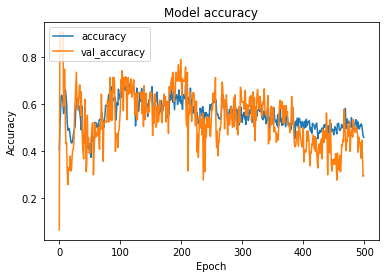

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

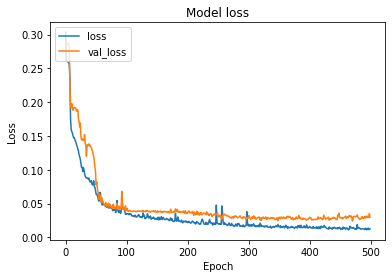

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')

plt.show()

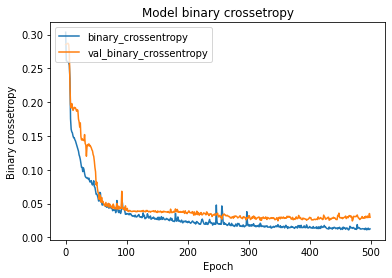

In [12]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [13]:
# predict new notes
prediction = model.predict(inputs_list, verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)


In [14]:
bpm = 120
file_name = "./output/output.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name)
create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid")

MidiFile(type=1, ticks_per_beat=960, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='meta_track', time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0)]),
  MidiTrack([
    Message('note_on', channel=9, note=36, velocity=80, time=0),
    Message('note_on', channel=9, note=40, velocity=80, time=0),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=36, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=0),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', chan

In [15]:
print(prediction)
print(instruments)

[[1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 0 0 0]]
[36, 40, 42, 46, 48, 49]
